In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv(r"D:\Fraud.csv")

In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.duplicated().sum()

0

# 1. Describe your fraud detection model in elaboration.
Main aim of fraud detection model is to flagg fraud customers making heavy transfers i.e in this case transfers > 200000 , and flag them as fraud customers. This customers can be potentially harmful to our banks as they try to exit money from the system in legitimate format while masking themself under umbrella of our banking system, exihibiting potential fraud. our target variable is designed in such a fashion which considers heavy transfer and fraudulent behaviour.Hence our model is useful to Flag of such fraud customers, hence taking various legal measures against them.

# CREATING TARGET VARIABLE IN ORDER TO FLAG FRAUD CUSTOMERS MAKING TRANSACTION GREATER THAN 200000

In [6]:
def set_flagged_fraud(row):
    if row['amount'] > 200000 and row['isFraud'] == 1:
        return 'Fraud'
    else:
        return 'Legal'

# Apply the custom function to each row in the DataFrame and update the "isFlaggedFraud" column
df['isFlaggedFraud'] = df.apply(set_flagged_fraud, axis=1)

In [7]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,Legal
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,Legal
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,Legal
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,Legal
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,Legal
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,Fraud
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,Fraud
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,Fraud
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,Fraud


In [8]:
df['isFlaggedFraud'].value_counts()

Legal    6357149
Fraud       5471
Name: isFlaggedFraud, dtype: int64

In [9]:
df.drop(['isFraud'], axis=1, inplace = True)

In [10]:
mask = df['amount'] < 1000
# Drop rows where the mask is True (i.e., 'amount' < 1000)
df.drop(df.index[mask], inplace=True)

In [11]:
changes = ['oldbalanceOrg','newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

def make_required_changes(row):
    for item in changes:
        if row[item] == 0.0:
            row[item] = 10.0
    return row

df = df.apply(make_required_changes, axis=1)

# 2.Data cleaning including missing values, outliers and multi-collinearity
Making our data normally distributed by reducing skewness and kurtosis and making them be in their acceptable range +-0.8 for skewness and +-3 kurtosis. There are zero null values and duplicate value in our data. In order to apply log transformations we need to manipulate our data point replacing minimum 0 values of transaction to atleast 10 or greater.multi collinearity can be detected by using VIF (variance influential factor) and co-relation heatmap. 

# EDA OF OUR DATA

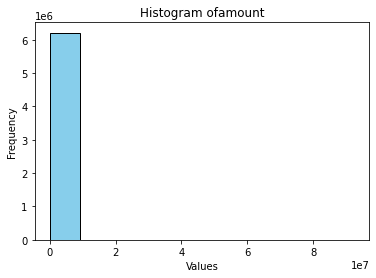

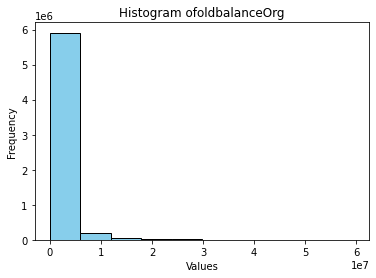

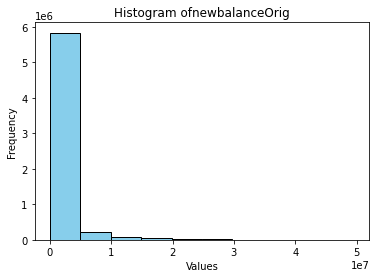

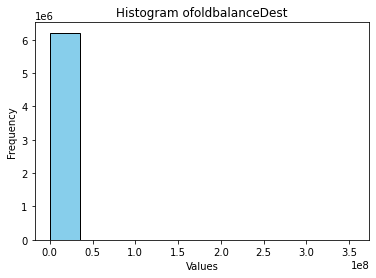

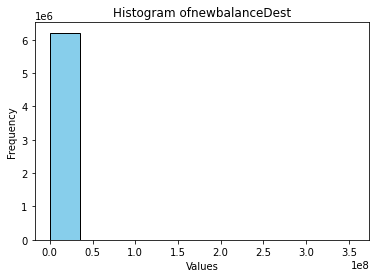

In [12]:
# Plot histogram for a all column
plot=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for item in plot:
    plt.hist(df[item], color='skyblue', edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of'+item)
    plt.show()

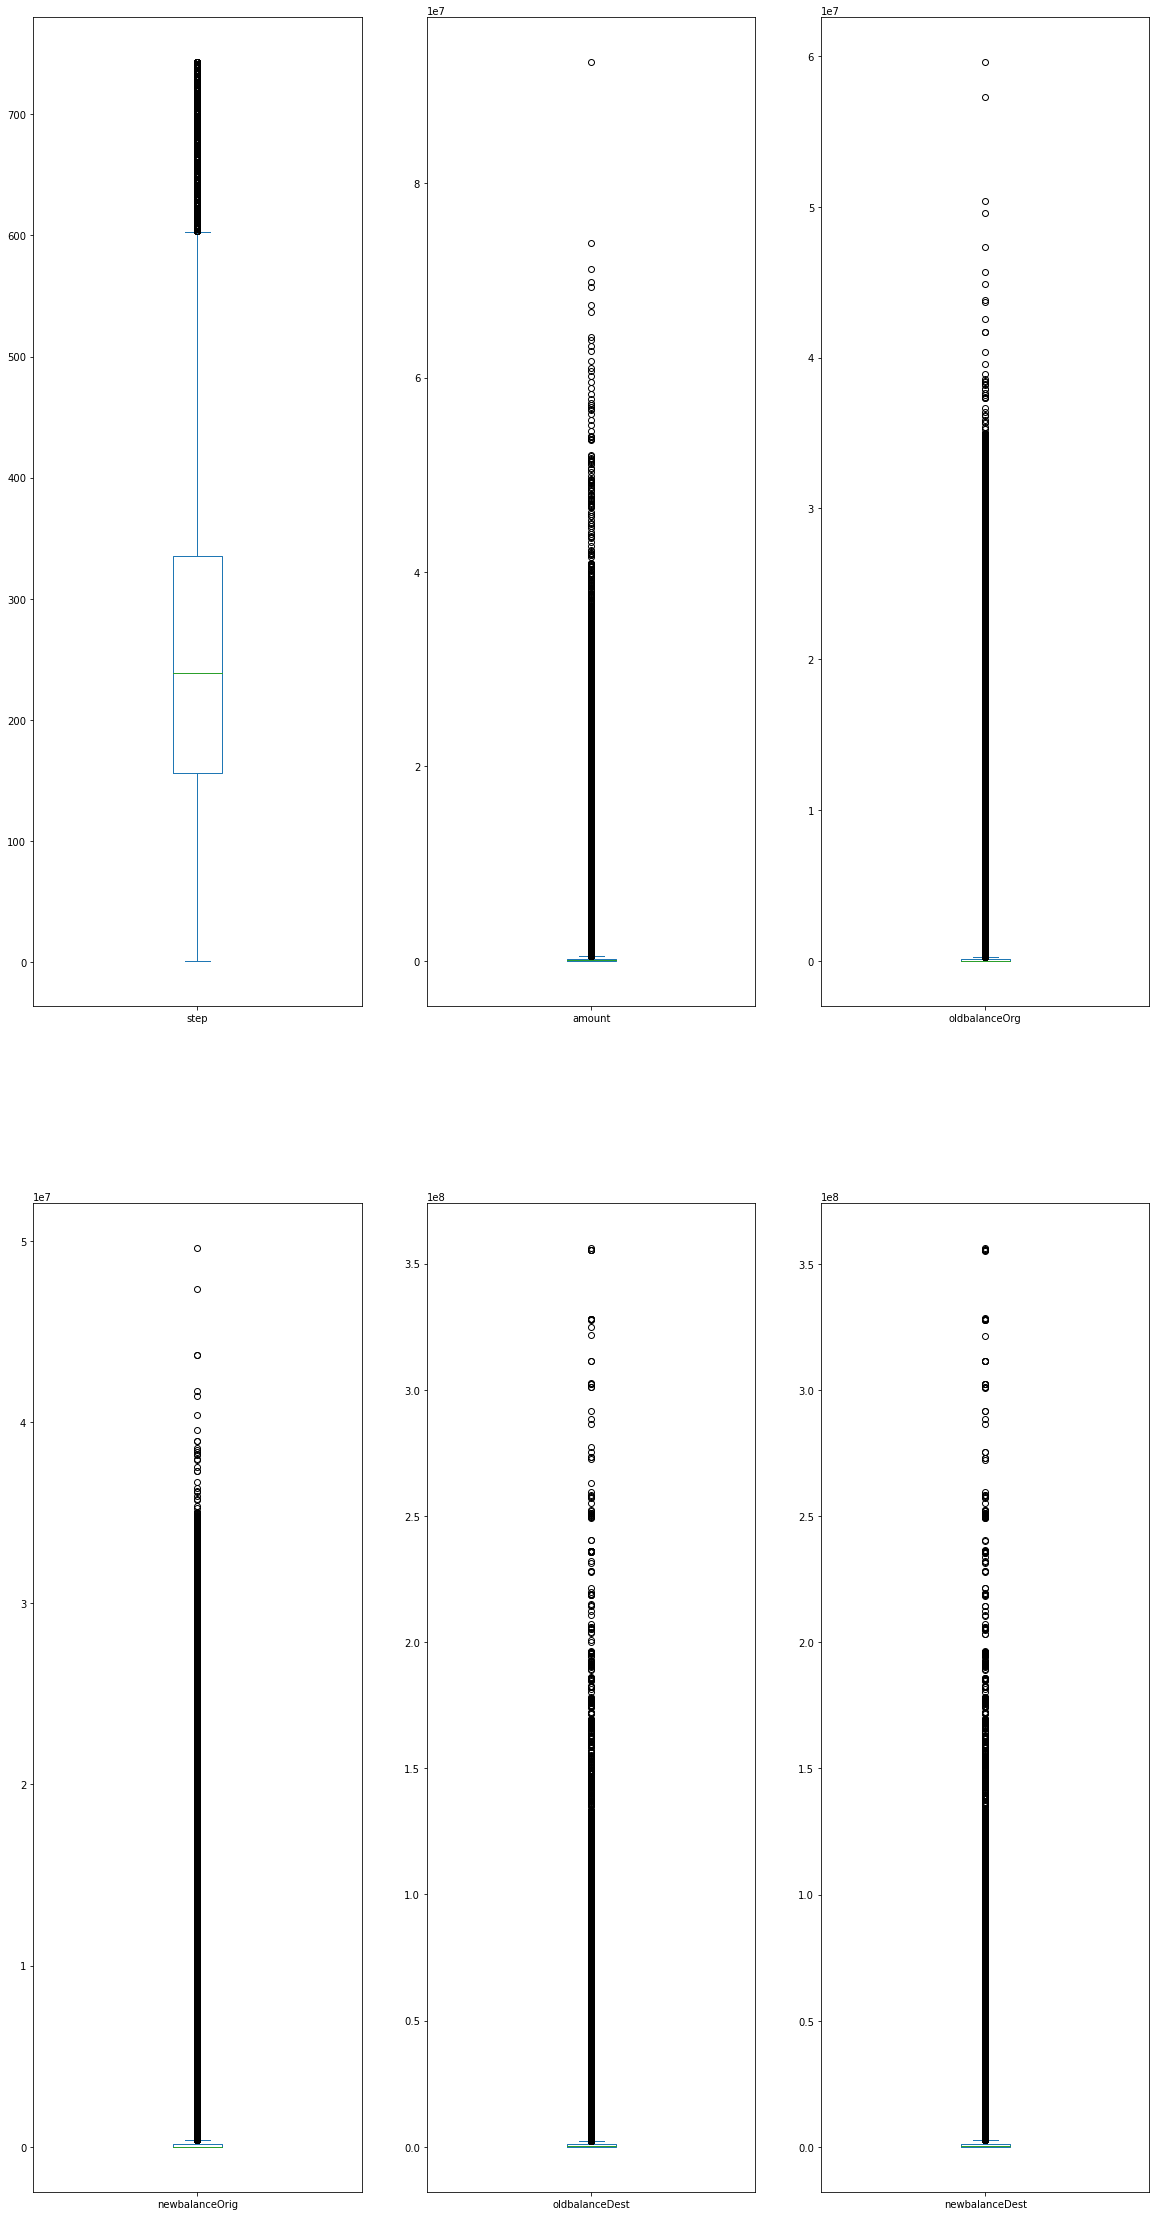

In [14]:
df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False,figsize=(20, 40))
plt.show()

# APPLYING LOG TRANSFORMATION TO INCREASE DATA QUALITY

In [15]:
changes = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Assuming you have a DataFrame called 'df', you can apply the logarithm like this:
df[changes] = np.log(df[changes])


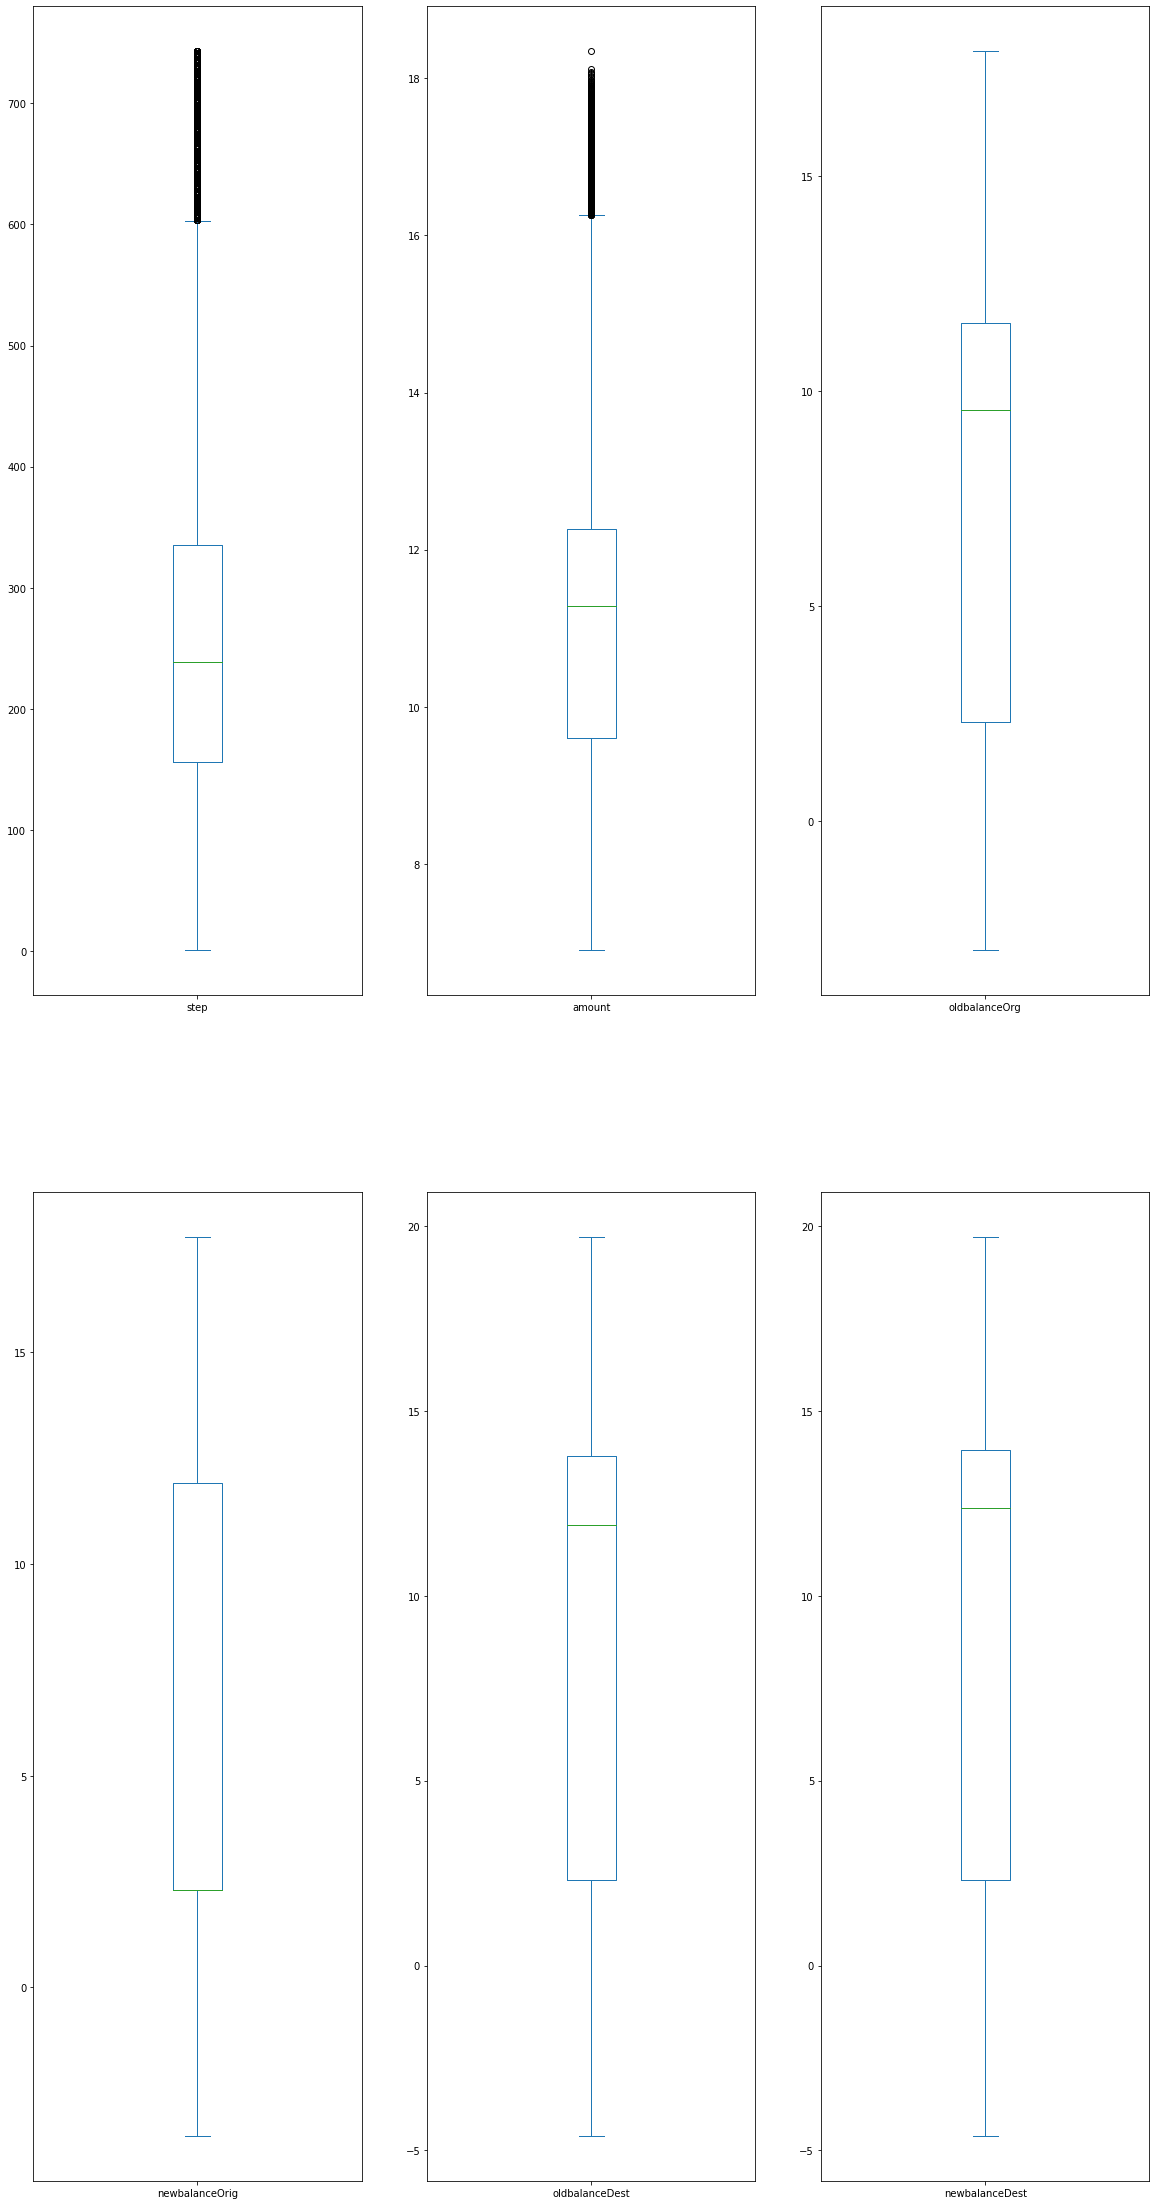

In [16]:
df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False,figsize=(20, 40))
plt.show()

In [17]:
 df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,PAYMENT,9.194174,C1231006815,12.044353,11.984780,M1979787155,2.302585,2.302585,Legal
1,1,PAYMENT,7.530630,C1666544295,9.964065,9.872240,M2044282225,2.302585,2.302585,Legal
4,1,PAYMENT,9.364617,C2048537720,10.634749,10.305141,M1230701703,2.302585,2.302585,Legal
5,1,PAYMENT,8.964147,C90045638,10.894143,10.737316,M573487274,2.302585,2.302585,Legal
6,1,PAYMENT,8.868944,C154988899,12.118306,12.078735,M408069119,2.302585,2.302585,Legal
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,12.735766,C786484425,12.735766,2.302585,C776919290,2.302585,12.735766,Fraud
6362616,743,TRANSFER,15.657870,C1529008245,15.657870,2.302585,C1881841831,2.302585,2.302585,Fraud
6362617,743,CASH_OUT,15.657870,C1162922333,15.657870,2.302585,C1365125890,11.134426,15.668663,Fraud
6362618,743,TRANSFER,13.652995,C1685995037,13.652995,2.302585,C2080388513,2.302585,2.302585,Fraud


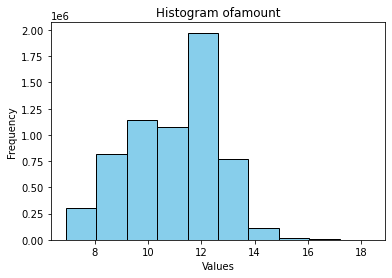

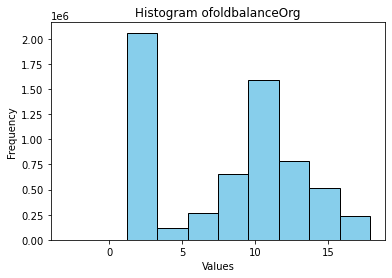

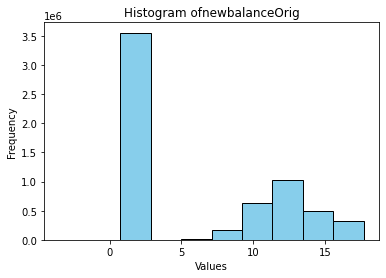

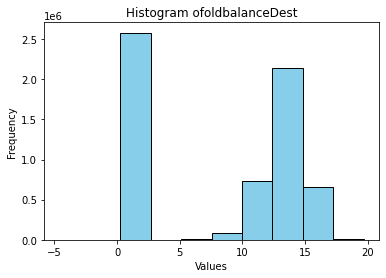

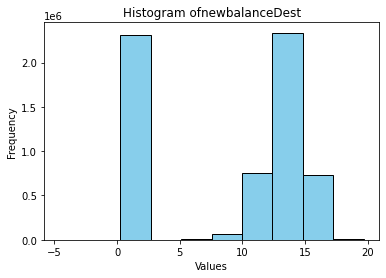

In [18]:
# Plot histogram for a all column
plot=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for item in plot:
    plt.hist(df[item], color='skyblue', edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of'+item)
    plt.show()

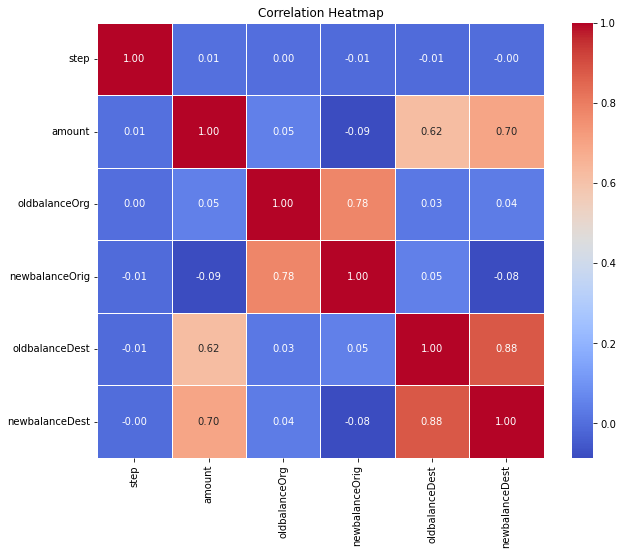

In [19]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Step 1: Prepare the data for the VIF test by adding a constant column
y = df['isFlaggedFraud']
numeric_df = df.select_dtypes(include=[np.number])

# Step 2: Handle missing or invalid values (e.g., fill missing values with column means)
numeric_df = numeric_df.fillna(numeric_df.mean())

X = add_constant(numeric_df)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

threshold = 5
multicollinear_features = vif_data[vif_data['VIF'] > threshold]['Feature']
print("Multicollinear features:", multicollinear_features)


Multicollinear features: 0             const
5    oldbalanceDest
6    newbalanceDest
Name: Feature, dtype: object


In [21]:
df.drop('newbalanceDest',axis=1, inplace=True)

# OUTLIER TREATMENT

In [52]:
z1=stats.zscore(df['amount'])
z2=stats.zscore(df['oldbalanceOrg'])
z3=stats.zscore(df['newbalanceOrig'])
z4=stats.zscore(df['oldbalanceDest'])

In [53]:
#insert the calculated z-Score into the dataframe
df1=df.copy()
df1.insert(0,"Z-Score_amount", list(z1), True)
df1.insert(0,"Z-Score_oldbalanceOrg", list(z2), True) 
df1.insert(0,"Z-Score_newbalanceOrg", list(z3), True) 
df1.insert(0,"Z-Score_oldbalanceDest", list(z4), True) 

In [56]:
df1.loc[df1['Z-Score_amount']>1.96,'amount']=np.nan
df1.loc[df1['Z-Score_amount']<-1.96,'amount']=np.nan

df1.loc[df1['Z-Score_oldbalanceOrg']>1.96,'oldbalanceOrg']=np.nan
df1.loc[df1['Z-Score_oldbalanceOrg']<-1.96,'oldbalanceOrg']=np.nan

df1.loc[df1['Z-Score_newbalanceOrg']>1.96,'newbalanceOrig']=np.nan
df1.loc[df1['Z-Score_newbalanceOrg']<-1.96,'newbalanceOrig']=np.nan

df1.loc[df1['Z-Score_oldbalanceDest']>1.96,'oldbalanceDest']=np.nan
df1.loc[df1['Z-Score_oldbalanceDest']<-1.96,'oldbalanceDest']=np.nan

In [57]:
df1

,Z-Score_oldbalanceDest,Z-Score_newbalanceOrg,Z-Score_oldbalanceOrg,Z-Score_amount,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,type_encoded,isFlaggedFraud_encoded
0,-1.160061,1.016116,0.820010,-1.055443,9.194174,12.044353,11.984780,2.302585,3,1
1,-1.160061,0.613544,0.377830,-2.053358,NaN,9.964065,9.872240,2.302585,3,1
4,-1.160061,0.696039,0.520389,-0.953199,9.364617,10.634749,10.305141,2.302585,3,1
5,-1.160061,0.778396,0.575525,-1.193431,8.964147,10.894143,10.737316,2.302585,3,1
6,-1.160061,1.034021,0.835729,-1.250540,8.868944,12.118306,12.078735,2.302585,3,1
...,...,...,...,...,...,...,...,...,...,...
6362615,-1.160061,-0.828954,0.966974,1.069061,12.735766,12.735766,2.302585,2.302585,1,0
6362616,-1.160061,-0.828954,1.588088,2.821951,NaN,15.657870,2.302585,2.302585,4,0
6362617,0.412449,-0.828954,1.588088,2.821951,NaN,15.657870,2.302585,11.134426,1,0
6362618,-1.160061,-0.828954,1.161938,1.619281,13.652995,13.652995,2.302585,2.302585,4,0


In [59]:
# imputing the median values in place of the NaN values
df1['amount']=df1['amount'].fillna(df1['amount'].median())
df1['oldbalanceOrg']=df1['oldbalanceOrg'].fillna(df1['oldbalanceOrg'].median())
df1['oldbalanceDest']=df1['oldbalanceDest'].fillna(df1['oldbalanceDest'].median())
df1['newbalanceOrig']=df1['newbalanceOrig'].fillna(df1['newbalanceOrig'].median())

In [61]:
df1.drop(['Z-Score_oldbalanceDest','Z-Score_newbalanceOrg','Z-Score_oldbalanceOrg','Z-Score_amount'],axis=1,inplace=True)

# DESCRIPTIVE STATISTICS

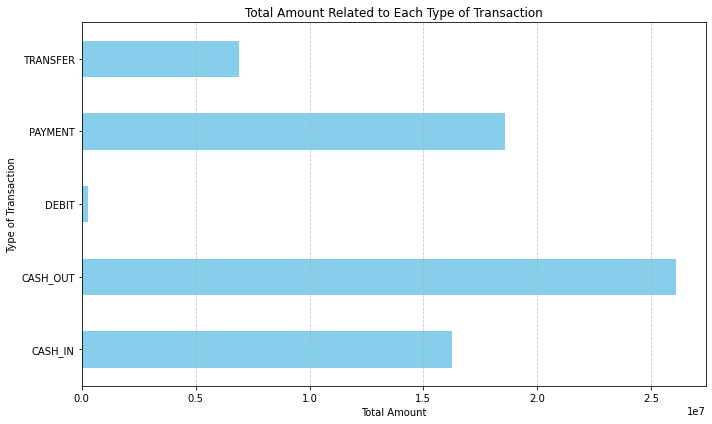

In [22]:
# Group the data by 'Type' and calculate the total amount for each type of transaction
transaction_totals = df.groupby('type')['amount'].sum()

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6)) 
transaction_totals.plot(kind='barh', color='skyblue')
plt.xlabel('Total Amount')
plt.ylabel('Type of Transaction')
plt.title('Total Amount Related to Each Type of Transaction')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

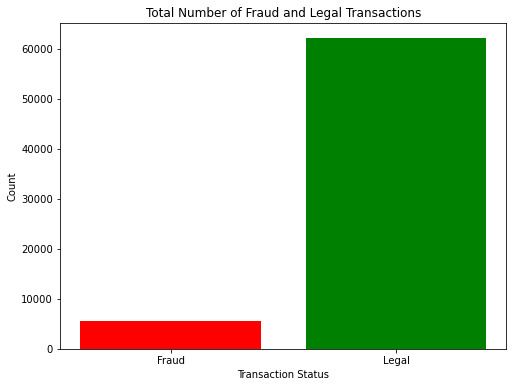

In [23]:
transaction_counts = df['isFlaggedFraud'].value_counts()
# Get the counts of fraud and legal transactions
total_fraud = transaction_counts[1] 
total_legal = transaction_counts[0] /100
# Plot the bar graph
plt.figure(figsize=(8, 6))  
plt.bar(['Fraud', 'Legal'], [total_fraud, total_legal], color=['red', 'green'])
plt.xlabel('Transaction Status')
plt.ylabel('Count')
plt.title('Total Number of Fraud and Legal Transactions')
plt.show()

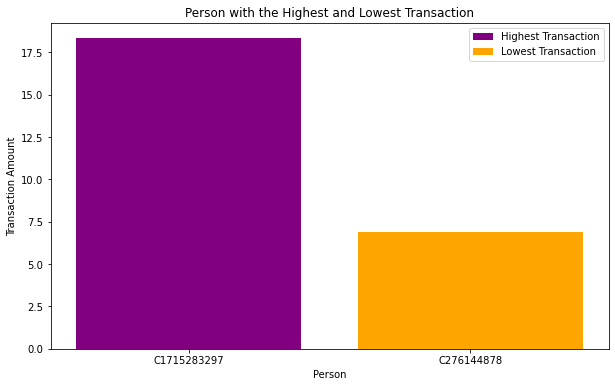

In [24]:
max_transaction_row = df[df['amount'] == df['amount'].max()]
lowest_transaction_row = df[df['amount'] == df['amount'].min()]

# Get the name and amount of the person with the highest and lowest transactions
person_with_highest_transaction = max_transaction_row['nameOrig'].iloc[0]
person_with_lowest_transaction = lowest_transaction_row['nameOrig'].iloc[0]
amount_highest_transaction = max_transaction_row['amount'].iloc[0]
amount_lowest_transaction = lowest_transaction_row['amount'].iloc[0]

plt.figure(figsize=(10, 6))  
plt.bar(person_with_highest_transaction, amount_highest_transaction, color='purple', label='Highest Transaction')
plt.bar(person_with_lowest_transaction, amount_lowest_transaction, color='orange', label='Lowest Transaction')
plt.xlabel('Person')
plt.ylabel('Transaction Amount')
plt.title('Person with the Highest and Lowest Transaction')
plt.legend()
plt.show()

# PREDICTIVE ANALYSIS 

# . How did you select variables to be included in the model?
Based on domain knowledge i dropped few in significant variables like customer name, step which could'nt make any significant impact to my machine learning model.Major impacting variables can be -
Amount,oldbalanceOrg,newbalanceOrig,oldbalanceDes as this help us to identify a pattern in our dataset based on the transaction amount and original balance of our payee and recipent of the transaction.

# . What are the key factors that predict fraudulent customer?. Do these factors make sense? If yes, How? If not, How not?
KEY FACTORS -TYPE OF PAYMENT, AMOUNT TRANSFERED ,INITIAL BALANCES OF PAYEE AND RECIPIENT OF TRANSACTION.THIS ARE USED TO PREDICT TARGET VARIABLE ISFLAGGEDFRAUD(0/1).
YES! THIS FACTOR MAKE SENSE AS THEY ARE VERY HELPFUL TO IDENTIFY TRENDS IN A PARTICULAR CUSTOMER IN REALTIME BASED ON THEIR FACTORS AS DISCUSSED ABOVE. 
A PARTICULAR CUSTOMER CAN BE FLAGGED FRAUD AT VERY EARLY STAGE WHICH WILL ENABLE US TO TARGET THOSE FRAUD PEOPLE BASED ON OUR ML ALGORITHM.

In [26]:
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFlaggedFraud
0,PAYMENT,9.194174,12.044353,11.984780,2.302585,Legal
1,PAYMENT,7.530630,9.964065,9.872240,2.302585,Legal
4,PAYMENT,9.364617,10.634749,10.305141,2.302585,Legal
5,PAYMENT,8.964147,10.894143,10.737316,2.302585,Legal
6,PAYMENT,8.868944,12.118306,12.078735,2.302585,Legal
...,...,...,...,...,...,...
6362615,CASH_OUT,12.735766,12.735766,2.302585,2.302585,Fraud
6362616,TRANSFER,15.657870,15.657870,2.302585,2.302585,Fraud
6362617,CASH_OUT,15.657870,15.657870,2.302585,11.134426,Fraud
6362618,TRANSFER,13.652995,13.652995,2.302585,2.302585,Fraud


In [27]:
# Initialize LabelEncoder for 'type' variable
type_label_encoder = LabelEncoder()

# Initialize LabelEncoder for 'isFlaggedFraud' variable
flagged_fraud_label_encoder = LabelEncoder()

# Label encode the 'type' and 'isFlaggedFraud' variables
df['type_encoded'] = type_label_encoder.fit_transform(df['type'])
df['isFlaggedFraud_encoded'] = flagged_fraud_label_encoder.fit_transform(df['isFlaggedFraud'])


In [29]:
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFlaggedFraud,type_encoded,isFlaggedFraud_encoded
0,PAYMENT,9.194174,12.044353,11.984780,2.302585,Legal,3,1
1,PAYMENT,7.530630,9.964065,9.872240,2.302585,Legal,3,1
4,PAYMENT,9.364617,10.634749,10.305141,2.302585,Legal,3,1
5,PAYMENT,8.964147,10.894143,10.737316,2.302585,Legal,3,1
6,PAYMENT,8.868944,12.118306,12.078735,2.302585,Legal,3,1
...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,12.735766,12.735766,2.302585,2.302585,Fraud,1,0
6362616,TRANSFER,15.657870,15.657870,2.302585,2.302585,Fraud,4,0
6362617,CASH_OUT,15.657870,15.657870,2.302585,11.134426,Fraud,1,0
6362618,TRANSFER,13.652995,13.652995,2.302585,2.302585,Fraud,4,0


In [30]:
df.drop(['type','isFlaggedFraud'], axis=1, inplace=True)

In [64]:
# Separate the features (X) and target variable (y)
X = df1[['amount', 'oldbalanceOrg','newbalanceOrig', 'oldbalanceDest', 'type_encoded']]
y = df1['isFlaggedFraud_encoded']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# RESAMPLING OUR TRAIN DATA TO GET UNBIASED MODEL

In [65]:
#  Create SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 4. Demonstrate the performance of the model by using best set of tools
LOGISTIC REGRESSION IS USED TO CLASSIFY OUR CUSTOMERS BEHAVIOURS BASED ON WHICH WE CAN IDENTIFY FRAUD OR LEGAL CUSTOMER IN OUR BANKING SYSTEM

In [66]:
logreg = LogisticRegression()
logreg.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [67]:
y_pred1 = logreg.predict(X_test)

In [68]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(y_test, y_pred1)
print("Classification Report:")
print(report)

Accuracy: 0.9740537750925244
Confusion Matrix:
[[   1080       9]
 [  32268 1210639]]
Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.99      0.06      1089
           1       1.00      0.97      0.99   1242907

    accuracy                           0.97   1243996
   macro avg       0.52      0.98      0.52   1243996
weighted avg       1.00      0.97      0.99   1243996



# 7. What kind of prevention should be adopted while company update its infrastructure?

# 8. Assuming these actions have been implemented, how would you determine if they work?
BY increasing efficiency of our machine learning algorithm making it capable of tracking fraud customers with heavy transfers.